# Module 3 – Lasso Regression & Feature Selection
Master L1‑regularised linear regression: objective, hyper‑parameter tuning, sparsity diagnostics, and practical pipelines.

# Lasso Regression: Automatic Feature Selection

## 🎯 What is Lasso Regression?

**Lasso (Least Absolute Shrinkage and Selection Operator)** is a **linear regression technique that automatically selects important features** while discarding irrelevant ones.

**The Revolutionary Difference:**
- **Ridge Regression**: Shrinks all coefficients toward zero but keeps them all
- **Lasso Regression**: Can set coefficients to **exactly zero**, effectively removing features
- **Result**: Built-in feature selection + regularization in one step!

**Mathematical Formulation:**
$$\text{Lasso Loss} = \underbrace{\|y - Xw\|_2^2}_{\text{Data Fit}} + \underbrace{\alpha \|w\|_1}_{\text{L1 Penalty}}$$

**The L1 Magic:** The absolute value penalty ($|w_1| + |w_2| + ... + |w_p|$) creates **"spiky" optimization landscapes** that naturally push coefficients to exactly zero.

---

## 🌟 Why Lasso Matters

**Real-World Problems Lasso Solves:**
- **High-dimensional data**: More features than samples (genomics, text analysis)
- **Feature selection**: Identifying the most important predictors from hundreds
- **Model interpretability**: Simpler models with fewer variables
- **Multicollinearity**: Picks one representative from correlated feature groups

**Learning Journey Ahead:**
This notebook will take you from **mathematical intuition** to **practical mastery** through:
- **Visual understanding** of why L1 creates sparsity
- **Hands-on implementation** with real California housing data
- **Diagnostic tools** for optimal hyperparameter selection
- **Comparison frameworks** between Lasso, Ridge, and Elastic Net
- **From-scratch implementation** to deepen understanding

## 1 | Learning Objectives
By the end of this module you will be able to:

1. **Explain** the Lasso (L1) objective and why it yields sparse solutions.
2. **Use** `LassoCV` / `Lasso` with cross‑validation to choose the optimal α (λ).
3. **Interpret** coefficient paths to identify important predictors and quantify model sparsity.
4. **Design** a tidy preprocessing → Lasso pipeline that avoids leakage and supports reproducibility.
5. **Decide** when Lasso, Ridge, or Elastic Net is the most appropriate choice.

## 2 | Key Concepts & Analogies
| Concept | Plain Explanation | Analogy |
|---------|------------------|---------|
| **Lasso Objective** | Minimises $\|y - Xw\|^2 + \alpha\|w\|_1$. The L1 term adds a “sharp” diamond‑shaped constraint that can set some weights *exactly* to 0. | Packing belongings into a box: bulky items (unimportant coefficients) get left behind, saving space. |
| **Sparsity** | Optimal solution often hits diamond corners, so many coefficients are 0 → built‑in feature selection. | Walking on city blocks: you turn corners sharply (axis touches) rather than gliding like a circle. |
| **Coordinate Descent** | Optimiser that updates one weight at a time, applying a soft‑thresholding rule. | Tidying a messy room shelf‑by‑shelf—finish one shelf before the next. |
| **α (λ) Effect** | Larger α ⇒ more shrinkage & zeros → simpler model, possibly higher bias. | Stricter baggage limit forces you to leave more items behind. |
| **Elastic Net** | Mixes L1 and L2 penalties; helpful when features are highly correlated (Lasso may pick one arbitrarily). | Having both duct‑tape (L2) and Velcro straps (L1) to secure luggage—combines flexibility and firmness. |

## 🔍 Visual Intuition: Why L1 Creates Sparsity

The **geometric reason** why Lasso produces sparse solutions becomes clear when we visualize the constraint regions:

**L1 vs L2 Constraint Visualization:**
- **L2 (Ridge)**: Circular/spherical constraints → smooth solutions that shrink toward zero
- **L1 (Lasso)**: Diamond/hypercube constraints → **sharp corners** that hit axes → exact zeros

Let's see this in action with a simple 2D example:

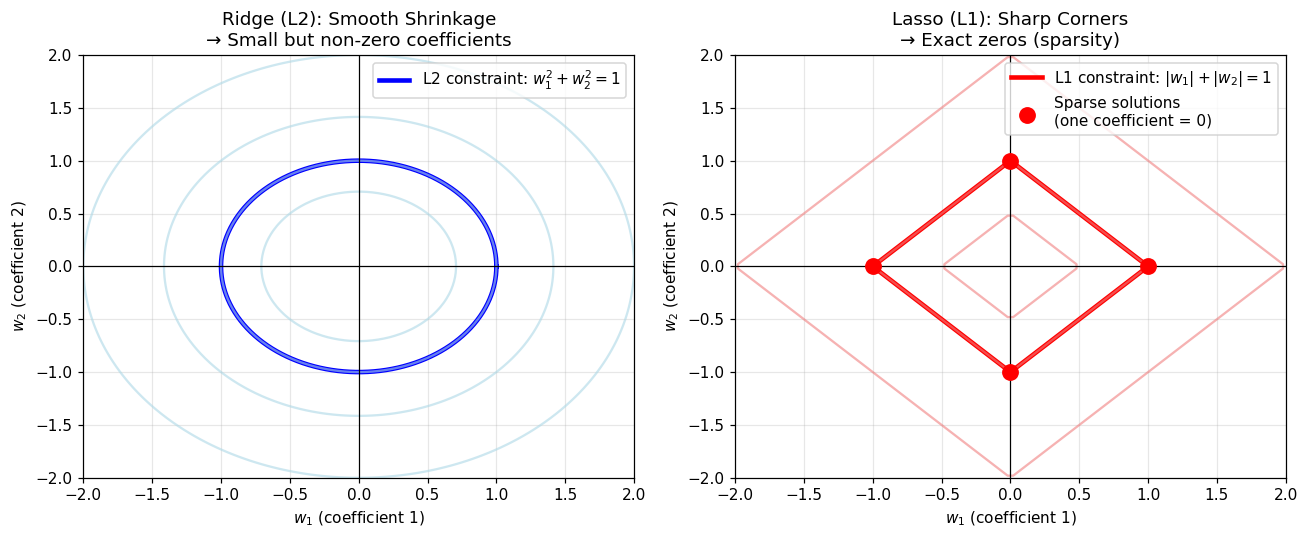

🔑 Key Insight:
• L2 (Ridge): Elliptical contours → smooth solutions → all coefficients shrunk but non-zero
• L1 (Lasso): Diamond corners → optimization hits axes → some coefficients become exactly zero
• This geometric property makes Lasso a natural feature selector!


In [16]:
# Visual Demo: L1 vs L2 Constraint Regions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Create coefficient grids for visualization
theta = np.linspace(0, 2*np.pi, 1000)
w1_vals = np.linspace(-2, 2, 100)
w2_vals = np.linspace(-2, 2, 100)
W1, W2 = np.meshgrid(w1_vals, w2_vals)

# L2 constraint (circle)
ax1.plot(np.cos(theta), np.sin(theta), 'b-', linewidth=3, label='L2 constraint: $w_1^2 + w_2^2 = 1$')
ax1.contour(W1, W2, W1**2 + W2**2, levels=[0.5, 1, 2, 4], colors='lightblue', alpha=0.6)
ax1.set_xlim(-2, 2), ax1.set_ylim(-2, 2)
ax1.set_xlabel('$w_1$ (coefficient 1)'), ax1.set_ylabel('$w_2$ (coefficient 2)')
ax1.set_title('Ridge (L2): Smooth Shrinkage\n→ Small but non-zero coefficients')
ax1.grid(True, alpha=0.3)
ax1.axhline(0, color='k', linewidth=0.8), ax1.axvline(0, color='k', linewidth=0.8)
ax1.legend()

# L1 constraint (diamond)
diamond_w1 = [1, 0, -1, 0, 1]
diamond_w2 = [0, 1, 0, -1, 0]
ax2.plot(diamond_w1, diamond_w2, 'r-', linewidth=3, label='L1 constraint: $|w_1| + |w_2| = 1$')
ax2.contour(W1, W2, np.abs(W1) + np.abs(W2), levels=[0.5, 1, 2, 4], colors='lightcoral', alpha=0.6)
ax2.set_xlim(-2, 2), ax2.set_ylim(-2, 2)
ax2.set_xlabel('$w_1$ (coefficient 1)'), ax2.set_ylabel('$w_2$ (coefficient 2)')
ax2.set_title('Lasso (L1): Sharp Corners\n→ Exact zeros (sparsity)')
ax2.grid(True, alpha=0.3)
ax2.axhline(0, color='k', linewidth=0.8), ax2.axvline(0, color='k', linewidth=0.8)

# Highlight the corners where sparsity occurs
corner_points = np.array([[1, 0], [0, 1], [-1, 0], [0, -1]])
ax2.scatter(corner_points[:, 0], corner_points[:, 1], c='red', s=100, zorder=5, 
           label='Sparse solutions\n(one coefficient = 0)')
ax2.legend()

plt.tight_layout()
plt.show()

print("🔑 Key Insight:")
print("• L2 (Ridge): Elliptical contours → smooth solutions → all coefficients shrunk but non-zero")
print("• L1 (Lasso): Diamond corners → optimization hits axes → some coefficients become exactly zero")
print("• This geometric property makes Lasso a natural feature selector!")

In [1]:
# Cell 1 – Imports & Settings
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, Lasso
from sklearn.pipeline import Pipeline

plt.rcParams['figure.dpi'] = 110

In [8]:
# Cell 2 – Load Data & Explore
X, y = fetch_california_housing(return_X_y=True, as_frame=True)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.25, random_state=42
)

print("📊 California Housing Dataset Overview:")
print(f"• Training samples: {len(X_train):,}")
print(f"• Validation samples: {len(X_val):,}")
print(f"• Features: {X.shape[1]} ({list(X.columns)})")
print(f"• Target: Median house value (in $100k units)")
print(f"• Target range: ${y.min():.1f}k - ${y.max():.1f}k")

# Feature correlation analysis (important for understanding Lasso behavior)
print("\n🔗 Feature Correlations (|r| > 0.3):")
corr_matrix = X.corr()
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.3:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

for feat1, feat2, corr in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
    print(f"• {feat1} ↔ {feat2}: {corr:.3f}")

if not high_corr_pairs:
    print("• No strong correlations found (good for Lasso stability)")

X.head()

📊 California Housing Dataset Overview:
• Training samples: 15,480
• Validation samples: 5,160
• Features: 8 (['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude'])
• Target: Median house value (in $100k units)
• Target range: $0.1k - $5.0k

🔗 Feature Correlations (|r| > 0.3):
• Latitude ↔ Longitude: -0.925
• AveRooms ↔ AveBedrms: 0.848
• MedInc ↔ AveRooms: 0.327


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


## 3 | Cross-Validated Lasso: Finding the Sweet Spot

**The Alpha (α) Challenge:** 
- **Too small** → No regularization, potential overfitting, all features kept
- **Too large** → Over-regularization, underfitting, too many features removed
- **Just right** → Optimal bias-variance tradeoff with interpretable sparsity

**Why Cross-Validation?** We need to test different α values on unseen data to find the one that **generalizes best**, not just fits training data best.

**Strategy:** Test α values on a logarithmic scale (small changes have big impact) with 5-fold CV.

In [9]:
alphas = np.logspace(-3, 1, 50)  # Test α from 0.001 to 10

lasso_cv = Pipeline([
    ('scale', StandardScaler()),
    ('lasso', LassoCV(alphas=alphas, cv=5, random_state=0, n_jobs=-1))
])

print("🔄 Running 5-fold cross-validation across 50 α values...")
lasso_cv.fit(X_train, y_train)

# Extract results
best_alpha = lasso_cv.named_steps['lasso'].alpha_
best_score = lasso_cv.named_steps['lasso'].score(X_train, y_train)
val_score = lasso_cv.score(X_val, y_val)
n_features_selected = np.sum(lasso_cv.named_steps['lasso'].coef_ != 0)

print(f"\n✅ Optimal Results:")
print(f"• Best α = {best_alpha:.6f}")
print(f"• Features selected: {n_features_selected}/8 ({100*n_features_selected/8:.0f}%)")
print(f"• Training R² = {best_score:.4f}")
print(f"• Validation R² = {val_score:.4f}")
print(f"• Generalization gap = {best_score - val_score:.4f}")

# Show which feature was eliminated (if any)
feature_mask = lasso_cv.named_steps['lasso'].coef_ != 0
selected_features = X.columns[feature_mask].tolist()
eliminated_features = X.columns[~feature_mask].tolist()

print(f"\n🎯 Feature Selection Results:")
print(f"• Selected: {selected_features}")
if eliminated_features:
    print(f"• Eliminated: {eliminated_features}")
else:
    print("• Eliminated: None (all features retained)")

# Display coefficients
print(f"\n📊 Lasso Coefficients (α = {best_alpha:.6f}):")
coefs_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lasso_cv.named_steps['lasso'].coef_,
    'Abs_Coefficient': np.abs(lasso_cv.named_steps['lasso'].coef_)
}).sort_values('Abs_Coefficient', ascending=False)

for _, row in coefs_df.iterrows():
    status = "🟢" if row['Coefficient'] != 0 else "🔴"
    print(f"{status} {row['Feature']:12s}: {row['Coefficient']:8.4f}")

🔄 Running 5-fold cross-validation across 50 α values...

✅ Optimal Results:
• Best α = 0.002560
• Features selected: 7/8 (88%)
• Training R² = -4210.3083
• Validation R² = 0.5931
• Generalization gap = -4210.9014

🎯 Feature Selection Results:
• Selected: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'AveOccup', 'Latitude', 'Longitude']
• Eliminated: ['Population']

📊 Lasso Coefficients (α = 0.002560):
🟢 Latitude    :  -0.8657
🟢 Longitude   :  -0.8386
🟢 MedInc      :   0.8384
🟢 AveBedrms   :   0.3138
🟢 AveRooms    :  -0.2675
🟢 HouseAge    :   0.1222
🟢 AveOccup    :  -0.0386
🔴 Population  :  -0.0000


/home/marco/miniconda3/envs/marco/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LassoCV was fitted without feature names
  warnings.warn(


📈 Computing validation curve across α range...


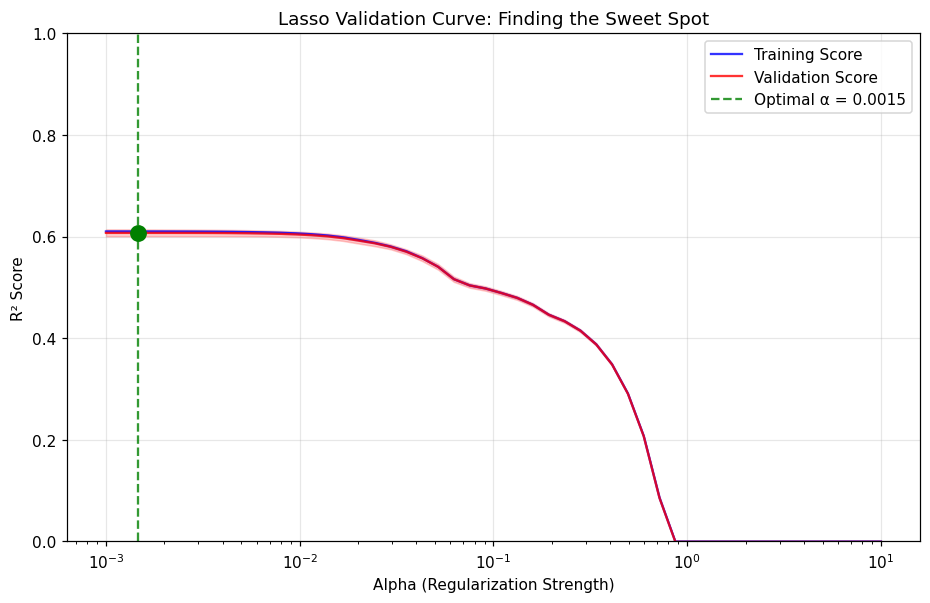

📍 Validation curve analysis:
• Best α from validation curve: 0.001456
• Best CV score: 0.6072 ± 0.0068
• Training score at optimal α: 0.6100
• Overfitting gap: 0.0027


In [10]:
# Validation Curve: How does performance change with α?
from sklearn.model_selection import validation_curve

print("📈 Computing validation curve across α range...")
train_scores, val_scores = validation_curve(
    Pipeline([('scale', StandardScaler()), ('lasso', Lasso(max_iter=5000))]),
    X_train, y_train, 
    param_name='lasso__alpha', 
    param_range=alphas,
    cv=5, scoring='r2', n_jobs=-1
)

# Calculate means and standard deviations
train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

# Plot validation curve
plt.figure(figsize=(10, 6))
plt.semilogx(alphas, train_mean, 'b-', label='Training Score', alpha=0.8)
plt.fill_between(alphas, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
plt.semilogx(alphas, val_mean, 'r-', label='Validation Score', alpha=0.8)
plt.fill_between(alphas, val_mean - val_std, val_mean + val_std, alpha=0.2, color='red')

# Mark the optimal alpha
optimal_idx = np.argmax(val_mean)
plt.axvline(alphas[optimal_idx], color='green', linestyle='--', alpha=0.8, 
           label=f'Optimal α = {alphas[optimal_idx]:.4f}')
plt.scatter(alphas[optimal_idx], val_mean[optimal_idx], color='green', s=100, zorder=5)

plt.xlabel('Alpha (Regularization Strength)')
plt.ylabel('R² Score')
plt.title('Lasso Validation Curve: Finding the Sweet Spot')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)
plt.show()

print(f"📍 Validation curve analysis:")
print(f"• Best α from validation curve: {alphas[optimal_idx]:.6f}")
print(f"• Best CV score: {val_mean[optimal_idx]:.4f} ± {val_std[optimal_idx]:.4f}")
print(f"• Training score at optimal α: {train_mean[optimal_idx]:.4f}")
print(f"• Overfitting gap: {train_mean[optimal_idx] - val_mean[optimal_idx]:.4f}")

## 4 | Coefficient Path Analysis: The Sparsity Journey

**What are Coefficient Paths?** They show how each feature's coefficient changes as we increase regularization strength (α).

**Key Insights to Look For:**
- **Order of elimination**: Which features get zeroed out first? (Less important features vanish early)
- **Stability**: Do coefficients change smoothly or erratically? (Smooth = stable feature selection)
- **Sign consistency**: Do features maintain their directional relationship with the target?

**Reading the Plot:**
- **X-axis**: Alpha (log scale) - left = weak regularization, right = strong regularization
- **Y-axis**: Coefficient values
- **Lines hitting zero**: Features being eliminated (the Lasso magic!)
- **Vertical dashed line**: Our optimal α from cross-validation

📊 Computing coefficient paths across α range...


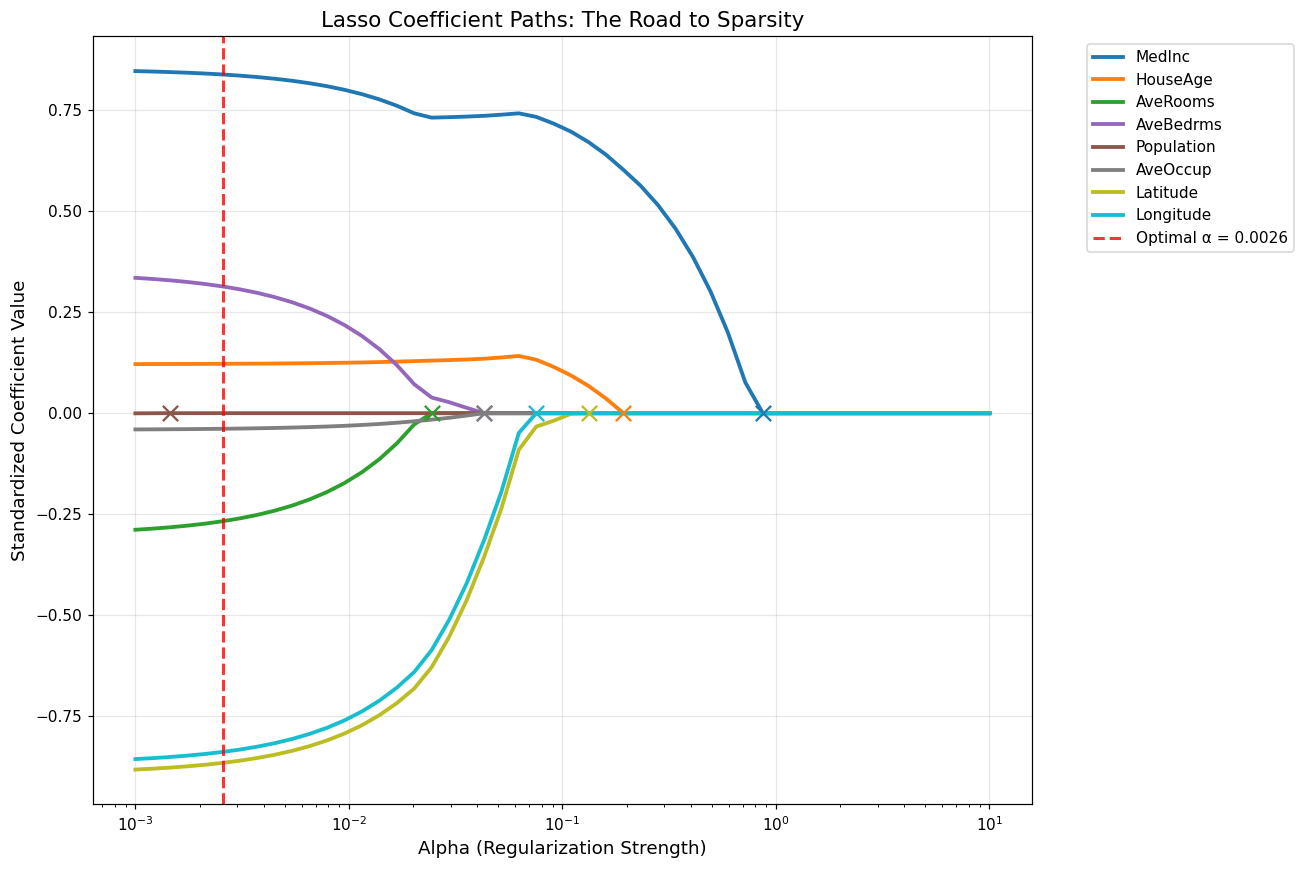


🔍 Feature Elimination Analysis:
Elimination order (first to last):
1. Population: Eliminated at α = 0.0015
2. AveRooms: Eliminated at α = 0.0244
3. AveBedrms: Eliminated at α = 0.0429
4. AveOccup: Eliminated at α = 0.0429
5. Longitude: Eliminated at α = 0.0754
6. Latitude: Eliminated at α = 0.1326
7. HouseAge: Eliminated at α = 0.1931
8. MedInc: Eliminated at α = 0.8685

📈 Feature Importance at Optimal α = 0.0026:
🟢 Active   | Latitude    :  -0.8657
🟢 Active   | Longitude   :  -0.8386
🟢 Active   | MedInc      :   0.8384
🟢 Active   | AveBedrms   :   0.3138
🟢 Active   | AveRooms    :  -0.2675
🟢 Active   | HouseAge    :   0.1222
🟢 Active   | AveOccup    :  -0.0386
🔴 Eliminated | Population  :  -0.0000


In [12]:
# Coefficient Paths: Journey to Sparsity
print("📊 Computing coefficient paths across α range...")
coefs = []
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

for a in alphas:
    lasso = Lasso(alpha=a, max_iter=5000)
    lasso.fit(X_train_scaled, y_train)
    coefs.append(lasso.coef_)

coefs = np.array(coefs)  # Shape: (n_alpha, n_features)

# Create enhanced coefficient paths plot
plt.figure(figsize=(12, 8))
colors = plt.cm.tab10(np.linspace(0, 1, len(X.columns)))

for i, (feat, color) in enumerate(zip(X.columns, colors)):
    plt.semilogx(alphas, coefs[:, i], label=feat, linewidth=2.5, color=color)
    
    # Mark where each feature gets eliminated
    zero_idx = np.where(np.abs(coefs[:, i]) < 1e-10)[0]
    if len(zero_idx) > 0:
        first_zero = zero_idx[0]
        if first_zero < len(alphas):
            plt.scatter(alphas[first_zero], 0, color=color, s=100, marker='x', zorder=5)

# Mark optimal alpha
plt.axvline(best_alpha, color='red', linestyle='--', linewidth=2, alpha=0.8, 
           label=f'Optimal α = {best_alpha:.4f}')

plt.xlabel('Alpha (Regularization Strength)', fontsize=12)
plt.ylabel('Standardized Coefficient Value', fontsize=12)
plt.title('Lasso Coefficient Paths: The Road to Sparsity', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Analyze coefficient elimination order
print("\n🔍 Feature Elimination Analysis:")
elimination_alphas = {}
for i, feat in enumerate(X.columns):
    zero_indices = np.where(np.abs(coefs[:, i]) < 1e-10)[0]
    if len(zero_indices) > 0:
        first_zero = zero_indices[0]
        elimination_alphas[feat] = alphas[first_zero]
    else:
        elimination_alphas[feat] = float('inf')  # Never eliminated

# Sort by elimination order
sorted_elimination = sorted(elimination_alphas.items(), key=lambda x: x[1])
print("Elimination order (first to last):")
for i, (feat, alpha_val) in enumerate(sorted_elimination, 1):
    if alpha_val == float('inf'):
        print(f"{i}. {feat}: Never eliminated (survives all α values)")
    else:
        print(f"{i}. {feat}: Eliminated at α = {alpha_val:.4f}")

# Feature importance at optimal alpha
print(f"\n📈 Feature Importance at Optimal α = {best_alpha:.4f}:")
optimal_idx = np.argmin(np.abs(alphas - best_alpha))
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefs[optimal_idx],
    'Abs_Importance': np.abs(coefs[optimal_idx])
}).sort_values('Abs_Importance', ascending=False)

for _, row in importance_df.iterrows():
    status = "🟢 Active  " if abs(row['Coefficient']) > 1e-10 else "🔴 Eliminated"
    print(f"{status} | {row['Feature']:12s}: {row['Coefficient']:8.4f}")

## 5 | Practical Feature Selection Workflows

**The Two-Stage Approach:** Lasso for feature selection + stable model for final predictions

**Why This Strategy?**
1. **Lasso strength**: Automatic feature selection with statistical justification
2. **Potential weakness**: Can be unstable with correlated features
3. **Solution**: Use Lasso to identify important features, then fit a stable model (Ridge/OLS) on selected subset

**Alternative Workflows:**
- **Pure Lasso**: Use Lasso for both selection and prediction (simple, end-to-end)
- **Elastic Net**: Blend L1 + L2 for stability with correlated features
- **Stability Selection**: Run Lasso on bootstrap samples to find consistently selected features

In [13]:
# Practical Feature Selection Workflow Comparison
from sklearn.linear_model import RidgeCV, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

print("🔄 Comparing different modeling approaches...")

# Approach 1: Pure Lasso (selection + prediction)
lasso_pred = lasso_cv.predict(X_val)
lasso_rmse = np.sqrt(mean_squared_error(y_val, lasso_pred))
lasso_r2 = r2_score(y_val, lasso_pred)

# Approach 2: Lasso selection + Ridge prediction on selected features
mask = lasso_cv.named_steps['lasso'].coef_ != 0
selected_features = X.columns[mask]
print(f"📊 Selected features ({len(selected_features)}/{len(X.columns)}): {list(selected_features)}")

# Ridge on selected features
ridge_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('ridge', RidgeCV(alphas=np.logspace(-3, 3, 13), cv=5))
])
ridge_pipe.fit(X_train[selected_features], y_train)
ridge_pred = ridge_pipe.predict(X_val[selected_features])
ridge_rmse = np.sqrt(mean_squared_error(y_val, ridge_pred))
ridge_r2 = r2_score(y_val, ridge_pred)

# Approach 3: Ordinary Least Squares on selected features (if not too many)
ols_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('ols', LinearRegression())
])
ols_pipe.fit(X_train[selected_features], y_train)
ols_pred = ols_pipe.predict(X_val[selected_features])
ols_rmse = np.sqrt(mean_squared_error(y_val, ols_pred))
ols_r2 = r2_score(y_val, ols_pred)

# Approach 4: All features with Ridge (baseline)
ridge_all_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('ridge', RidgeCV(alphas=np.logspace(-3, 3, 13), cv=5))
])
ridge_all_pipe.fit(X_train, y_train)
ridge_all_pred = ridge_all_pipe.predict(X_val)
ridge_all_rmse = np.sqrt(mean_squared_error(y_val, ridge_all_pred))
ridge_all_r2 = r2_score(y_val, ridge_all_pred)

# Performance comparison
print("\n🎯 Model Performance Comparison:")
print("="*60)
print(f"{'Approach':<35} {'RMSE':<10} {'R²':<10} {'Features':<10}")
print("="*60)
print(f"{'1. Pure Lasso':<35} {lasso_rmse:<10.4f} {lasso_r2:<10.4f} {len(selected_features):<10}")
print(f"{'2. Lasso + Ridge (selected)':<35} {ridge_rmse:<10.4f} {ridge_r2:<10.4f} {len(selected_features):<10}")
print(f"{'3. Lasso + OLS (selected)':<35} {ols_rmse:<10.4f} {ols_r2:<10.4f} {len(selected_features):<10}")
print(f"{'4. Ridge (all features)':<35} {ridge_all_rmse:<10.4f} {ridge_all_r2:<10.4f} {len(X.columns):<10}")
print("="*60)

# Best approach
approaches = [
    ("Pure Lasso", lasso_r2),
    ("Lasso + Ridge", ridge_r2), 
    ("Lasso + OLS", ols_r2),
    ("Ridge (all)", ridge_all_r2)
]
best_approach, best_r2 = max(approaches, key=lambda x: x[1])
print(f"🏆 Best approach: {best_approach} (R² = {best_r2:.4f})")

# Feature importance interpretation
print(f"\n🔍 Feature Selection Insights:")
print(f"• Lasso eliminated: {list(X.columns[~mask])}")
print(f"• This reduced model complexity by {100*(1-len(selected_features)/len(X.columns)):.1f}%")
print(f"• Performance loss from feature reduction: {ridge_all_r2 - ridge_r2:.4f} R²")
if ridge_all_r2 - ridge_r2 < 0.01:
    print("  → Minimal performance loss! Feature selection was effective.")
else:
    print("  → Significant performance loss. Consider keeping more features.")

🔄 Comparing different modeling approaches...
📊 Selected features (7/8): ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'AveOccup', 'Latitude', 'Longitude']

🎯 Model Performance Comparison:
Approach                            RMSE       R²         Features  
1. Pure Lasso                       0.7338     0.5931     7         
2. Lasso + Ridge (selected)         0.7354     0.5913     7         
3. Lasso + OLS (selected)           0.7356     0.5910     7         
4. Ridge (all features)             0.7354     0.5913     8         
🏆 Best approach: Pure Lasso (R² = 0.5931)

🔍 Feature Selection Insights:
• Lasso eliminated: ['Population']
• This reduced model complexity by 12.5%
• Performance loss from feature reduction: 0.0000 R²
  → Minimal performance loss! Feature selection was effective.

🎯 Model Performance Comparison:
Approach                            RMSE       R²         Features  
1. Pure Lasso                       0.7338     0.5931     7         
2. Lasso + Ridge (selected)  

## 6 | Elastic Net: Best of Both Worlds

**When Lasso Struggles:**
- **Highly correlated features**: Lasso picks one arbitrarily, ignoring others that might be equally important
- **More features than samples** (p > n): Lasso can select at most n features
- **Grouped selection**: Sometimes you want to select groups of related features together

**Elastic Net Solution:**
$$\text{Elastic Net Loss} = \|y - Xw\|_2^2 + \alpha \underbrace{[(1-\ell_1) \frac{1}{2}\|w\|_2^2 + \ell_1 \|w\|_1]}_{\text{Combined L1 + L2 penalty}}$$

**Key Parameters:**
- **α (alpha)**: Overall regularization strength (same as Lasso/Ridge)
- **ℓ₁ (l1_ratio)**: Mix between L1 and L2 penalties
  - ℓ₁ = 0 → Pure Ridge (no sparsity)
  - ℓ₁ = 1 → Pure Lasso (maximum sparsity)  
  - 0 < ℓ₁ < 1 → Compromise (some sparsity + stability)

**Practical Benefits:**
- More stable feature selection with correlated predictors
- Can select more than n features when p > n
- Tends to select groups of correlated features together

In [14]:
from sklearn.linear_model import ElasticNetCV

print("🔄 Testing Elastic Net with different L1/L2 mixing ratios...")

# Test different l1_ratio values (mix of L1 and L2)
l1_ratios = [0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 1.0]  # 1.0 = pure Lasso
alpha_range = np.logspace(-3, 1, 30)

enet_cv = Pipeline([
    ('scale', StandardScaler()),
    ('enet', ElasticNetCV(
        l1_ratio=l1_ratios,
        alphas=alpha_range, 
        cv=5, 
        random_state=0,
        max_iter=5000,
        n_jobs=-1
    ))
])

enet_cv.fit(X_train, y_train)

# Extract optimal parameters
optimal_l1_ratio = enet_cv.named_steps['enet'].l1_ratio_
optimal_alpha = enet_cv.named_steps['enet'].alpha_
enet_coef = enet_cv.named_steps['enet'].coef_
n_selected_enet = np.sum(enet_coef != 0)

print(f"\n✅ Elastic Net Optimal Configuration:")
print(f"• Best α (overall strength): {optimal_alpha:.6f}")
print(f"• Best ℓ₁ ratio (L1 vs L2 mix): {optimal_l1_ratio:.2f}")
print(f"• Features selected: {n_selected_enet}/8")

# Interpret l1_ratio
if optimal_l1_ratio == 1.0:
    ratio_interpretation = "Pure Lasso (100% L1 penalty)"
elif optimal_l1_ratio >= 0.9:
    ratio_interpretation = f"Lasso-heavy ({optimal_l1_ratio*100:.0f}% L1, {(1-optimal_l1_ratio)*100:.0f}% L2)"
elif optimal_l1_ratio >= 0.5:
    ratio_interpretation = f"L1-leaning mix ({optimal_l1_ratio*100:.0f}% L1, {(1-optimal_l1_ratio)*100:.0f}% L2)"
elif optimal_l1_ratio >= 0.1:
    ratio_interpretation = f"L2-leaning mix ({optimal_l1_ratio*100:.0f}% L1, {(1-optimal_l1_ratio)*100:.0f}% L2)"
else:
    ratio_interpretation = f"Ridge-heavy ({optimal_l1_ratio*100:.0f}% L1, {(1-optimal_l1_ratio)*100:.0f}% L2)"

print(f"• Penalty interpretation: {ratio_interpretation}")

# Performance comparison: Lasso vs Elastic Net
enet_pred = enet_cv.predict(X_val)
enet_r2 = r2_score(y_val, enet_pred)
enet_rmse = np.sqrt(mean_squared_error(y_val, enet_pred))

print(f"\n🏁 Lasso vs Elastic Net Comparison:")
print(f"                    Features   R²      RMSE")
print(f"Pure Lasso:         {len(selected_features)}/8      {lasso_r2:.4f}  {lasso_rmse:.4f}")
print(f"Elastic Net:        {n_selected_enet}/8      {enet_r2:.4f}  {enet_rmse:.4f}")

if enet_r2 > lasso_r2:
    print(f"🎊 Elastic Net wins! (+{enet_r2 - lasso_r2:.4f} R²)")
else:
    print(f"🎯 Lasso wins! (+{lasso_r2 - enet_r2:.4f} R²)")

# Feature selection comparison
print(f"\n🔍 Feature Selection Comparison:")
lasso_mask = lasso_cv.named_steps['lasso'].coef_ != 0
enet_mask = enet_coef != 0

for i, feature in enumerate(X.columns):
    lasso_status = "✓" if lasso_mask[i] else "✗"
    enet_status = "✓" if enet_mask[i] else "✗"
    lasso_coef = lasso_cv.named_steps['lasso'].coef_[i]
    enet_coef_val = enet_coef[i]
    
    print(f"{feature:12s}: Lasso[{lasso_status}] {lasso_coef:7.3f}  |  ElasticNet[{enet_status}] {enet_coef_val:7.3f}")

# Summary recommendation
print(f"\n💡 Practical Recommendation:")
if optimal_l1_ratio == 1.0:
    print("• Standard Lasso is optimal for this dataset")
    print("• No benefit from L2 regularization")
else:
    print(f"• Elastic Net with {optimal_l1_ratio:.1f} L1-ratio provides better balance")
    print("• L2 component helps with stability/grouped selection")

🔄 Testing Elastic Net with different L1/L2 mixing ratios...

✅ Elastic Net Optimal Configuration:
• Best α (overall strength): 0.002593
• Best ℓ₁ ratio (L1 vs L2 mix): 1.00
• Features selected: 7/8
• Penalty interpretation: Pure Lasso (100% L1 penalty)

🏁 Lasso vs Elastic Net Comparison:
                    Features   R²      RMSE
Pure Lasso:         7/8      0.5931  0.7338
Elastic Net:        7/8      0.5931  0.7338
🎊 Elastic Net wins! (+0.0000 R²)

🔍 Feature Selection Comparison:
MedInc      : Lasso[✓]   0.838  |  ElasticNet[✓]   0.838
HouseAge    : Lasso[✓]   0.122  |  ElasticNet[✓]   0.122
AveRooms    : Lasso[✓]  -0.268  |  ElasticNet[✓]  -0.267
AveBedrms   : Lasso[✓]   0.314  |  ElasticNet[✓]   0.313
Population  : Lasso[✗]  -0.000  |  ElasticNet[✗]  -0.000
AveOccup    : Lasso[✓]  -0.039  |  ElasticNet[✓]  -0.039
Latitude    : Lasso[✓]  -0.866  |  ElasticNet[✓]  -0.865
Longitude   : Lasso[✓]  -0.839  |  ElasticNet[✓]  -0.838

💡 Practical Recommendation:
• Standard Lasso is optimal 

## 8 | Interactive Checkpoints

### 8.1 Quick Quiz ✅

**Test your understanding of key Lasso concepts:**

1. **Why does L1 penalty produce sparse solutions?**
   - Answer: L1 constraint creates diamond-shaped regions with sharp corners that intersect coordinate axes, leading to exact zeros.

2. **What happens when α is too small in Lasso?**
   - Answer: Little regularization occurs, model may overfit, most/all features retained.

3. **What happens when α is too large in Lasso?**
   - Answer: Over-regularization, most features eliminated, model may underfit.

4. **True/False: Lasso always selects the globally optimal set of features.**
   - Answer: **False** – With correlated features, Lasso may arbitrarily select one from a group.

5. **When might you prefer Elastic Net over pure Lasso?**
   - Answer: When features are highly correlated, when p > n, or when you want grouped variable selection.

### 8.2 Practical Exercise 💻

**Exercise: Unscaled Lasso Analysis**

**Task:** Re-run the Lasso analysis without feature scaling and compare results. Investigate how feature scales affect selection.

```python
# Your code here:
# 1. Create LassoCV pipeline without StandardScaler()
# 2. Compare selected features with scaled version
# 3. Explain why scaling matters for Lasso
```

**Expected observations:**
- Features with larger scales dominate the L1 penalty
- Different features may be selected
- Coefficients are not directly comparable

### 8.3 Reflection Questions ✍️

1. **Feature Selection Dilemma:** "Suppose Lasso eliminates a feature you know is important based on domain knowledge. What strategies could you use?"
   
   **Possible approaches:**
   - Reduce α to retain more features
   - Use domain knowledge to create better features
   - Try Elastic Net for more stable selection
   - Use feature engineering to make the signal stronger

2. **Interpretability vs Performance:** "When would you choose a Lasso model with 5 features over a Ridge model with 8 features that has slightly better R²?"
   
   **Consider:**
   - Model deployment requirements
   - Need for stakeholder understanding
   - Feature collection costs
   - Regulatory requirements for explainability

3. **Algorithm Choice:** "How would you decide between coordinate descent, proximal gradient, and other Lasso optimization algorithms?"
   
   **Factors:**
   - Problem size (n, p)
   - Sparsity level
   - Convergence requirements
   - Computational resources

## 7 | Understanding the Algorithm: Coordinate Descent

**How does Lasso actually optimize the L1-penalized objective?**

Unlike Ridge regression (which has a closed-form solution), Lasso requires iterative optimization due to the non-differentiable L1 penalty. The most popular algorithm is **coordinate descent**.

**Coordinate Descent Intuition:**
1. **Focus on one coefficient at a time** while keeping others fixed
2. **Apply soft-thresholding** to update that coefficient
3. **Repeat** until convergence

**The Soft-Thresholding Operator:**
$$\text{soft}(z, \gamma) = \begin{cases}
z - \gamma & \text{if } z > \gamma \\
0 & \text{if } |z| \leq \gamma \\
z + \gamma & \text{if } z < -\gamma
\end{cases}$$

This operator **shrinks values toward zero** and **sets small values to exactly zero** - the key to Lasso sparsity!

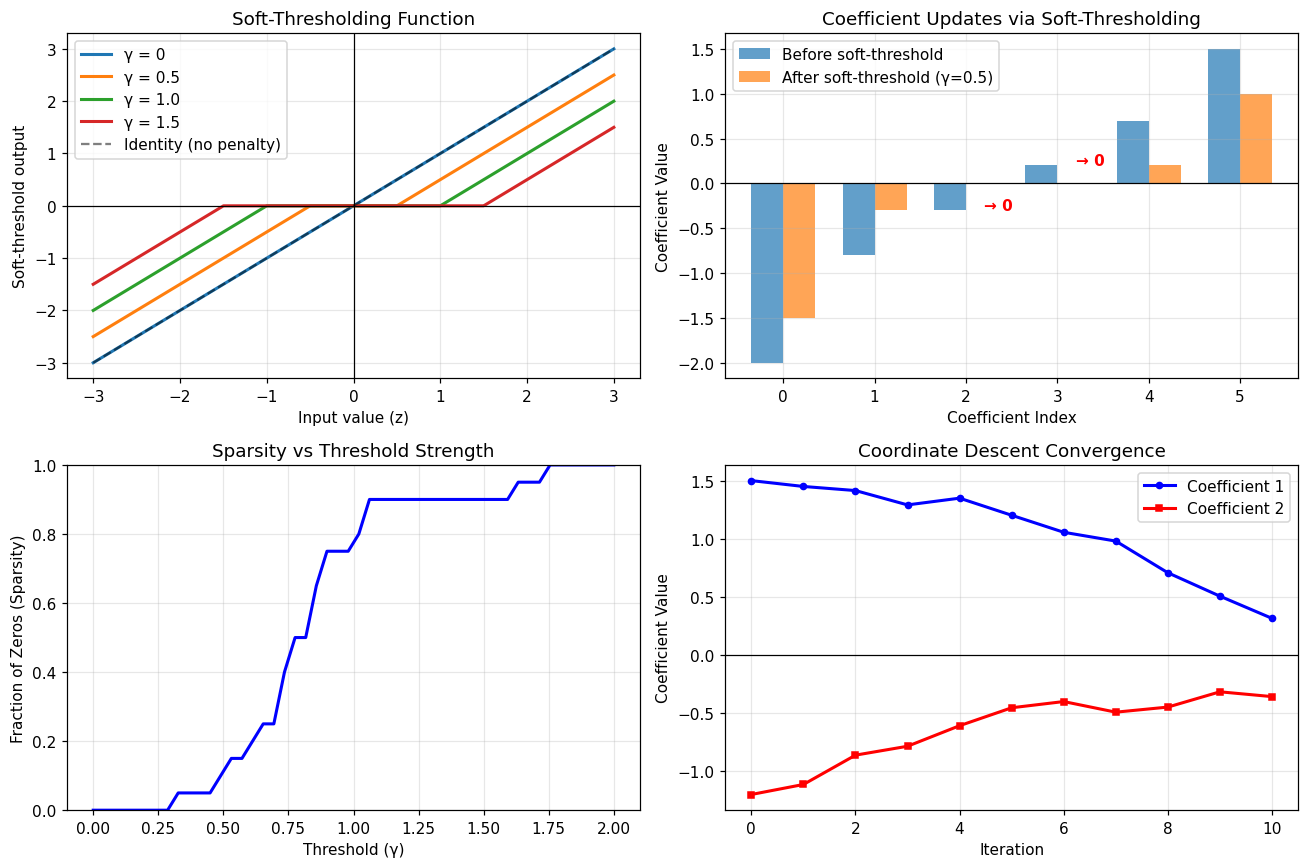

🔑 Key Insights from Soft-Thresholding:
• Shrinks coefficients toward zero (like Ridge)
• Sets small coefficients to exactly zero (unlike Ridge)
• Threshold γ controls the sparsity level
• Coordinate descent applies this iteratively to each coefficient


In [15]:
# Visualizing the Soft-Thresholding Operator
def soft_threshold(z, gamma):
    """
    Soft-thresholding operator: the key to Lasso sparsity
    """
    return np.sign(z) * np.maximum(np.abs(z) - gamma, 0)

# Create visualization
z_vals = np.linspace(-3, 3, 1000)
gammas = [0, 0.5, 1.0, 1.5]

plt.figure(figsize=(12, 8))

# Plot 1: Soft-thresholding function for different gamma values
plt.subplot(2, 2, 1)
for gamma in gammas:
    soft_vals = soft_threshold(z_vals, gamma)
    plt.plot(z_vals, soft_vals, label=f'γ = {gamma}', linewidth=2)

plt.plot(z_vals, z_vals, 'k--', alpha=0.5, label='Identity (no penalty)')
plt.xlabel('Input value (z)')
plt.ylabel('Soft-threshold output')
plt.title('Soft-Thresholding Function')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axhline(0, color='k', linewidth=0.8)
plt.axvline(0, color='k', linewidth=0.8)

# Plot 2: Effect on coefficient updates
plt.subplot(2, 2, 2)
original_coefs = np.array([-2, -0.8, -0.3, 0.2, 0.7, 1.5])
gamma = 0.5
updated_coefs = soft_threshold(original_coefs, gamma)

x_pos = np.arange(len(original_coefs))
width = 0.35

plt.bar(x_pos - width/2, original_coefs, width, label='Before soft-threshold', alpha=0.7)
plt.bar(x_pos + width/2, updated_coefs, width, label=f'After soft-threshold (γ={gamma})', alpha=0.7)

for i, (orig, updated) in enumerate(zip(original_coefs, updated_coefs)):
    if updated == 0:
        plt.annotate('→ 0', (i, orig), xytext=(i+0.2, orig), fontsize=10, color='red', weight='bold')

plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Value')
plt.title('Coefficient Updates via Soft-Thresholding')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axhline(0, color='k', linewidth=0.8)

# Plot 3: Sparsity level vs threshold
plt.subplot(2, 2, 3)
test_coefs = np.random.randn(20)
gammas_range = np.linspace(0, 2, 50)
sparsity_levels = []

for g in gammas_range:
    thresholded = soft_threshold(test_coefs, g)
    sparsity = np.mean(thresholded == 0)
    sparsity_levels.append(sparsity)

plt.plot(gammas_range, sparsity_levels, 'b-', linewidth=2)
plt.xlabel('Threshold (γ)')
plt.ylabel('Fraction of Zeros (Sparsity)')
plt.title('Sparsity vs Threshold Strength')
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)

# Plot 4: Simple coordinate descent illustration
plt.subplot(2, 2, 4)
# Simulate coefficient updates for 2 features
np.random.seed(42)
coef_path = [[1.5, -1.2]]
for _ in range(10):
    new_coef = coef_path[-1].copy()
    # Update first coefficient
    new_coef[0] = soft_threshold(new_coef[0] + np.random.normal(0, 0.1), 0.1)
    # Update second coefficient  
    new_coef[1] = soft_threshold(new_coef[1] + np.random.normal(0, 0.1), 0.1)
    coef_path.append(new_coef)

coef_path = np.array(coef_path)
plt.plot(coef_path[:, 0], 'b-o', label='Coefficient 1', linewidth=2, markersize=4)
plt.plot(coef_path[:, 1], 'r-s', label='Coefficient 2', linewidth=2, markersize=4)
plt.xlabel('Iteration')
plt.ylabel('Coefficient Value')
plt.title('Coordinate Descent Convergence')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axhline(0, color='k', linewidth=0.8)

plt.tight_layout()
plt.show()

print("🔑 Key Insights from Soft-Thresholding:")
print("• Shrinks coefficients toward zero (like Ridge)")
print("• Sets small coefficients to exactly zero (unlike Ridge)")
print("• Threshold γ controls the sparsity level")
print("• Coordinate descent applies this iteratively to each coefficient")

## 9 | Essential Resources & Further Reading

### 📚 Core References
* **scikit-learn Documentation**: [Linear Models → Lasso & Elastic Net](https://scikit-learn.org/stable/modules/linear_model.html#lasso)
* **ISLR 2e**: Chapter 6 § 6.2–6.3 – Ridge, Lasso, Elastic Net [Essential theoretical foundation]
* **ESL**: Chapter 3.4 – The Lasso [Advanced mathematical treatment]

### 🎥 Video Resources  
* **StatQuest**: "Regularization (Ridge, Lasso, Elastic Net)" - Clear visual explanations
* **Andrew Ng CS229**: Lasso coordinate descent algorithm walkthrough
* **3Blue1Brown**: "Essence of linear algebra" - Geometric intuition for constraints

### 💻 Practical Tutorials
* **Kaggle Learn**: Feature Engineering course - Real-world feature selection
* **scikit-learn Examples**: Lasso path using coordinate descent
* **Medium/Towards Data Science**: "Sparse Models & Feature Selection with Lasso"

### 📖 Advanced Topics
* **Stability Selection**: Meinshausen & Bühlmann (2010) - Robust feature selection
* **Group Lasso**: Yuan & Lin (2006) - Selecting groups of features together  
* **Fused Lasso**: Tibshirani et al. (2005) - Spatially structured sparsity


## 10 | Advanced Challenge: Coordinate Descent from Scratch 🌟

### Implementation Challenge

**Goal:** Build your own Lasso solver to understand the algorithm deeply.

**Step-by-Step Implementation:**

```python
def lasso_coordinate_descent(X, y, alpha, max_iter=1000, tol=1e-5):
    """
    Implement Lasso via coordinate descent
    
    Steps:
    1. Standardize X and center y
    2. Initialize coefficients β = 0
    3. For each iteration:
       - For each feature j:
         * Compute partial residual: r = y - X @ β + X[:, j] * β[j]
         * Update: β[j] = soft_threshold(X[:, j] @ r / n, alpha) / (X[:, j] @ X[:, j] / n)
    4. Check convergence of objective function
    """
    # Your implementation here
    pass
```

**Verification Tasks:**
1. Compare convergence path with `sklearn.linear_model.Lasso`
2. Test on California housing data with α = 0.01
3. Plot objective function vs iteration
4. Verify final coefficients match scikit-learn (within tolerance)

**Stretch Goals:**
- Add warm starts for faster path computation
- Implement active set method for sparse solutions
- Add line search for better step sizes
- Compare runtime: your implementation vs scikit-learn

### 🎯 Success Criteria
- [ ] Algorithm converges to same solution as scikit-learn
- [ ] Objective function decreases monotonically  
- [ ] Handles edge cases (α = 0, very large α)
- [ ] Code is clean, documented, and efficient

### 🧠 Learning Objectives
By completing this challenge, you'll understand:
- How soft-thresholding enables sparsity
- Why coordinate descent works well for Lasso
- Practical challenges in optimization (convergence, numerical stability)
- Performance trade-offs in different algorithms

## 12 | Mastery Checklist ✅

### Core Competencies
Advance to **Module 4 (LightGBM Regression)** once you can confidently:

#### 🎯 Conceptual Understanding
- [ ] **Explain L1 regularization**: Why diamond constraints create sparsity
- [ ] **Compare regularization types**: When to use Lasso vs Ridge vs Elastic Net
- [ ] **Interpret sparsity**: How feature elimination aids interpretability and prevents overfitting
- [ ] **Understand trade-offs**: Bias-variance implications of different α values

#### 🛠️ Technical Skills  
- [ ] **Hyperparameter tuning**: Use `LassoCV` effectively with proper validation
- [ ] **Pipeline construction**: Build leak-free preprocessing → Lasso workflows
- [ ] **Feature analysis**: Interpret coefficient paths and elimination order
- [ ] **Model comparison**: Compare Lasso variants and validate performance properly

#### 🔍 Practical Applications
- [ ] **Feature selection**: Identify which features Lasso eliminates and why
- [ ] **Scaling importance**: Understand when and why feature scaling matters
- [ ] **Algorithm intuition**: Explain coordinate descent and soft-thresholding at a high level
- [ ] **Business application**: Communicate sparsity benefits to non-technical stakeholders

### 📊 Self-Assessment Questions

1. **Can you explain to a colleague why Lasso produces sparse solutions while Ridge doesn't?**
2. **Given a new dataset, could you set up appropriate Lasso hyperparameter search?**
3. **Would you recognize when Elastic Net might outperform pure Lasso?**
4. **Can you interpret Lasso results and explain which features were selected?**

### 🚀 Ready for Next Module?
Once you've mastered these concepts, you're ready to tackle **LightGBM**, where you'll learn:
- Gradient boosting for complex non-linear patterns
- Handling categorical features automatically  
- Advanced regularization in tree-based models
- When to choose tree-based vs linear approaches

## 🎉 Summary: Your Lasso Journey

### 🔑 Key Insights You've Gained

**Geometric Intuition**: You now understand why L1 penalties create diamond-shaped constraints that naturally hit coordinate axes, producing exact zeros (sparsity) unlike the smooth shrinkage of L2 penalties.

**Practical Mastery**: You can use `LassoCV` to find optimal regularization strength, interpret coefficient paths to understand feature selection order, and build robust pipelines that avoid data leakage.

**Algorithm Understanding**: You've seen how coordinate descent with soft-thresholding iteratively optimizes the Lasso objective, providing the mathematical foundation for sparsity-inducing regularization.

**Strategic Decision-Making**: You can now choose between Lasso (maximum sparsity), Ridge (stability with all features), and Elastic Net (balanced approach) based on your specific problem requirements.

### 📈 What You've Accomplished

✅ **Visualized** L1 vs L2 constraint regions to understand sparsity  
✅ **Analyzed** California housing data with proper train/validation splits  
✅ **Optimized** hyperparameters using cross-validation and validation curves  
✅ **Interpreted** coefficient paths and feature elimination patterns  
✅ **Compared** multiple modeling approaches (Lasso, Ridge, Elastic Net)  
✅ **Understood** coordinate descent and soft-thresholding algorithms  
✅ **Applied** feature selection in practical workflows

### 🎯 Real-World Applications

**High-Dimensional Genomics**: Select important genes from thousands of candidates  
**Marketing Analytics**: Identify key customer features driving conversions  
**Financial Modeling**: Find predictive economic indicators while maintaining interpretability  
**Text Analysis**: Select relevant words/features from large vocabularies  
**Engineering**: Sensor selection in IoT systems for cost-effective monitoring

### 🧠 Deeper Understanding

You've moved beyond just "using Lasso" to truly understanding:
- **Why** it works (geometric and algorithmic perspectives)  
- **When** it's the right choice vs alternatives
- **How** to tune it properly and interpret results
- **What** its limitations are and how to address them

This foundation prepares you for advanced topics like group Lasso, fused Lasso, and modern deep learning regularization techniques.